## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [1]:
import sys,os,shutil,subprocess
import glob
import random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from io import StringIO
import pathogenie as pg
import snipgenie
from snipgenie import app,tools,plotting,wgmlst,trees,clustering
import toytree, toyplot

In [63]:
#meta = pd.read_csv('/storage/btbgenie/monaghan/metadata/isolates_master.csv')
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')

## create reference proteins for MLST

In [5]:
#prots = wgmlst.make_reference_proteins()
#res = wgmlst.get_nucleotide_sequences(app.mbovis_gb,'Mbovis_AF212297_nuc.fa')

3994


## initialise MLST table from reference genome

In [63]:
def setup_db():
    """Setup initial db"""
    
    #filter only Mb proteins in scheme
    mlst=pd.read_csv('mlst_scheme.csv')
    mlst=mlst[mlst['Ridom Usage']=='MLST+']
    targets=list(mlst.Target)    
    #bovis-tb mapping
    mbmap=pd.read_csv('final_mbovis_mapping.csv')
    mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
    mb_tags = list(mbmap.Mb_tag)
    #prots = tools.fasta_to_dataframe()
    #prots = prots[prots.locus_tag.isin(mb_tags)]
    nucseqs = tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
    nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

    #set up initial mlst table with reference sequences 
    cols = ['name','allele','sequence']
    ref = nucseqs.copy()
    ref['allele'] = 1
    ref=ref.rename(columns={'translation':'sequence'})
    ref[cols].to_csv('mbovis_db.csv.gz',index=False,compression='gzip')
    print (len(ref))    
    
setup_db()

/home/farrell/gitprojects/snipgenie/snipgenie/tools.py:385: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[key] = df[key].str.replace('|','_')


3184


## assembly

In [ ]:
reload(tools)
assembly_path = '/storage/btbgenie/mlst_assembly_test/'

for i,r in samples.iterrows():
    name=r['sample']
    print (name)
    out = os.path.join(assembly_path,name+'.fa')
    print (out)
    tools.spades(r.filename1, r.filename2, os.path.join(assembly_path,name), outfile=out, threads=12)

## test annotation

In [ ]:
reload(wgmlst)
seqfile='/storage/btbgenie/mlst_assembly_test/1034.fa'
#seqfile='consensus.fa'
featdf,recs = pg.run_annotation(seqfile, threads=10, kingdom='bacteria', trusted=wgmlst.ref_proteins)
annotfile='/storage/btbgenie/mlst_assembly_test/1034.gb'

#write out nucl sequence
SeqIO.write(recs,annotfile,'genbank')
#make nuc sequences - used for typing
outfile = '/storage/btbgenie/mlst_assembly_test/1034_proteins.fa'
res = wgmlst.get_nucleotide_sequences(annotfile,outfile,idkey='protein_id')

In [ ]:
#fastafile='/storage/btbgenie/annotation_assembly/1034.fa'
#df = pg.tools.fasta_to_dataframe(fastafile)
#df[df.name=='Mb0014c']

## test typing

In [ ]:
reload(wgmlst)
assembly='/storage/btbgenie/mlst_assembly_test/1034.fa'

cmd = 'ragtag.py scaffold {r} {q}'.format(r=app.mbovis_genome,q=assembly)
#print (cmd)
#testfile='/storage/btbgenie/ragtag_output/ragtag.scaffold.fasta'
prof,new = wgmlst.find_alleles(outfile)
#wgmlst.update_mlst_db(new)
print (len(prof))

In [ ]:
reload(wgmlst)
#all typing in one go
res = wgmlst.type_sample('consensus.fa', annotfile, outfile, threads=10)

## find distances between mlst profiles

In [13]:
def diff_profiles(s1, s2):    
    return sum(1 for a, b in zip(s1, s2) if a != b)

In [263]:
import random
test = {'A':[1,1,1,2,2,3,3],'B':[1,2,2,3,2,3,3],'C':[1,2,2,3,2,3,1],'D':[1,2,2,3,2,3,1]}
test = pd.DataFrame(test).T
print (test)
d = wgmlst.dist_matrix(test)
d

   0  1  2  3  4  5  6
A  1  1  1  2  2  3  3
B  1  2  2  3  2  3  3
C  1  2  2  3  2  3  1
D  1  2  2  3  2  3  1


,A,B,C,D
A,0,3,4,4
B,3,0,1,1
C,4,1,0,0
D,4,1,0,0


## tree from profiles

In [ ]:
def make_neighbor_joining_tree(df):
    """Neighbour joining tree with biopython"""
    
    from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
    from Bio.Phylo.TreeConstruction import DistanceMatrix
    
    def lower_matrix(matrix):
        #get lower matrix as non-sparse lists
        i=0
        m=[]
        for n in range(1,matrix.shape[0]+1):
            m.append(list(x[i:i+n]))
            i+=n
        return m
    
    data = df.values
    labels = list(df.index)
    
    matrix = lower_matrix(data)
    dm = DistanceMatrix(labels, matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)
    return tree

# Create a DistanceMatrix object using a list of labels and a list of distances
labels = ['A', 'B', 'C', 'D']
matrix = [[0, 1, 2, 3], [1, 0, 4, 5], [2, 4, 0, 6], [3, 5, 6, 0]]
df = pd.DataFrame(matrix,index=labels,columns=labels)
print (df)
# Call the make_neighbor_joining_tree function to create the tree
tree = make_neighbor_joining_tree(df)

print (tree)
# Print the tree in Newick format
print(tree.format("newick"))
tre = toytree.tree(tree.format("newick"))

In [ ]:
tree = wgmlst.tree_from_distmatrix(df)
print(tree.ascii_art())

## test on wicklow samples

In [206]:
vcf_file='/storage/btbgenie/wicklow_results/snps.vcf.gz'

In [ ]:
reload(wgmlst)
reload(tools)
samples = pd.read_csv('/storage/btbgenie/wicklow_results/samples.csv')
#subset=list(samples.sample(8)['sample'])
subset = ['29-MBovis','24-MBovis','27-MBovis'] #'47-MBovis'
profs = wgmlst.run_samples(samples, '/storage/btbgenie/mlst_assembly_test/', threads=12, names=subset)

In [ ]:
def update_profiles(new):
    
    current = pd.read_csv(wgmlst.sample_profiles)
    new = pd.concat([current,new])
    print (new)

In [255]:
profs.T

,24-MBovis,27-MBovis,29-MBovis
0,1,2,2
1,1,2,2
2,1,2,2
3,1,2,2
4,2,3,3
...,...,...,...
3179,1,2,2
3180,1,2,2
3181,2,3,3
3182,1,2,2


In [222]:
#profs.to_csv(wgmlst.sample_profiles,mode='a',index=True)
update_profiles(new)

In [ ]:
pd.read_csv('wgmlst_profiles.csv',index_col=0)

## all ireland samples

In [223]:
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
vcf_file='/storage/btbgenie/all_ireland_results/snps.vcf.gz'

In [224]:
subset=list(samples.sample(10)['sample'])

In [ ]:
profs = wgmlst.run_samples(vcf_file, '/storage/btbgenie/mlst_consensus_test/', threads=12, names=subset)

## clustering and strain naming

In [252]:
DM = wgmlst.dist_matrix(profs)
tree = wgmlst.tree_from_distmatrix(DM)
tree.write('tree.newick')
clusts,members = clustering.get_cluster_levels(DM)

In [256]:
DM

,24-MBovis,27-MBovis,29-MBovis
24-MBovis,0,1843,1239
27-MBovis,1843,0,1194
29-MBovis,1239,1194,0


In [253]:
X=meta.set_index('SeqID').loc[DM.index]
st = clustering.generate_strain_names(clusts,X)
#st.to_csv('wgmlst_strains.csv')
X=X.join(st)

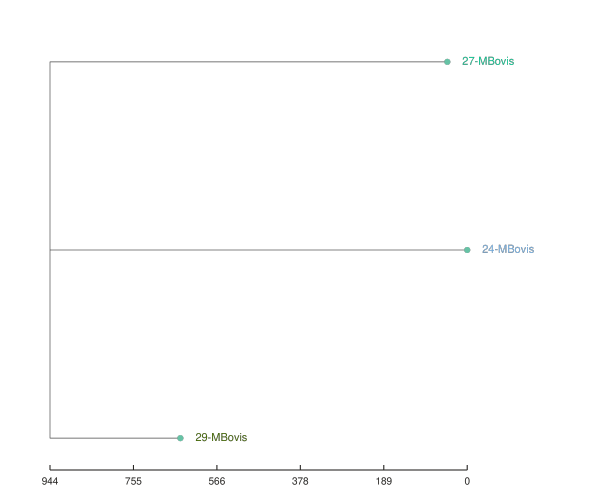

In [254]:
scol='snp200'
#scol='County'
reload(trees)
trees.draw_tree('tree.newick',X,scol,tip_labels=True,width=600)#,cmap=clustering.snp200_cmap)

In [ ]:
import networkx as nx
G= nx.erdos_renyi_graph(n=20,p=0.2)
T = nx.minimum_spanning_tree(G)
nx.draw(T)

In [ ]:
cg = sns.clustermap(DM, cmap='Blues', row_colors=X.color,figsize=(6,6),xticklabels=False,yticklabels=False)
cm=dict(zip(X[scol],X.color))
p=plotting.make_legend(cg.fig, cm, loc=(1.2, .9), title='cluster',fontsize=10)

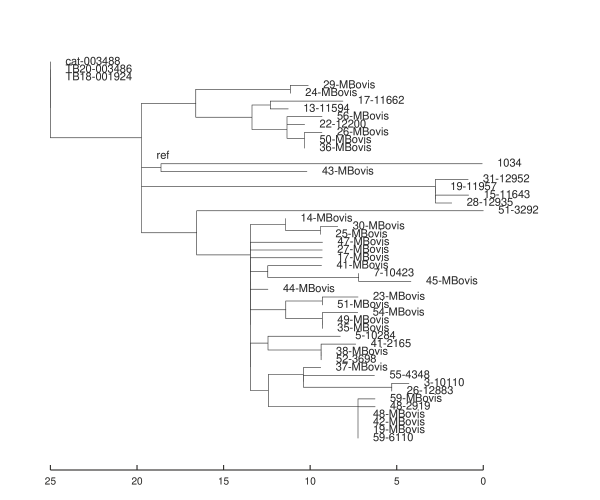

In [194]:
trees.draw_tree('/storage/btbgenie/wicklow_results/tree.newick',tip_labels=True,width=600)

,29-MBovis,24-MBovis,47-MBovis,27-MBovis
29-MBovis,0,0,1,2
24-MBovis,0,0,1,2
47-MBovis,1,1,0,1
27-MBovis,2,2,1,0


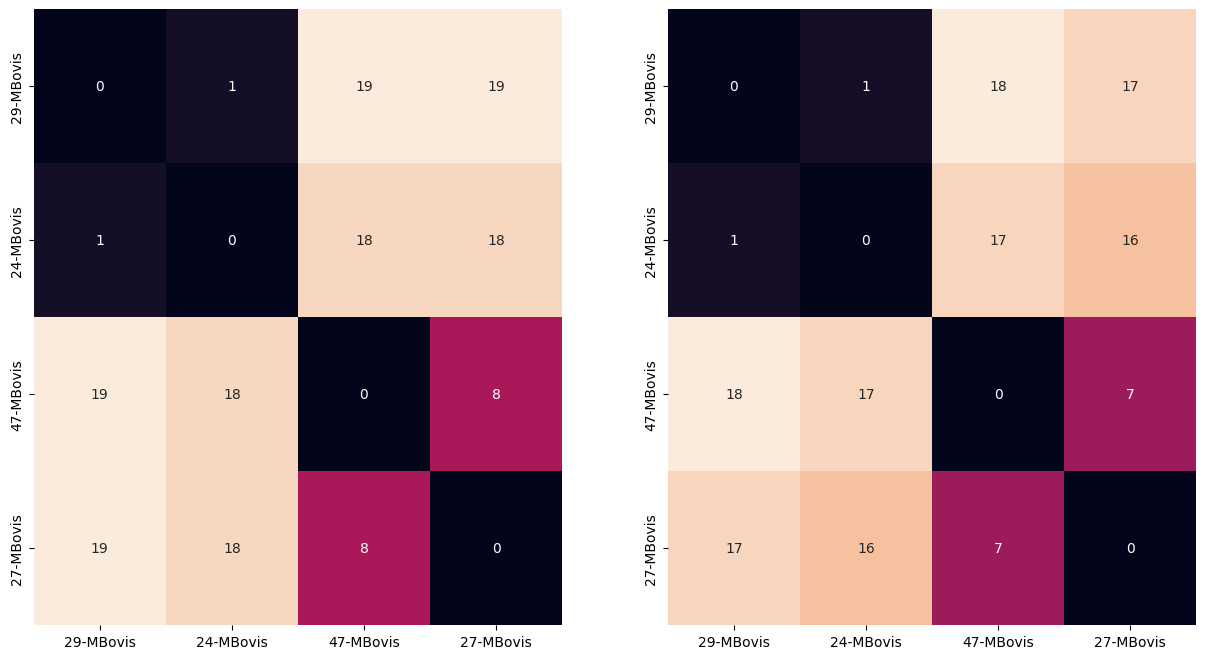

In [216]:
sd=pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv',index_col=0)
sub = list(X.index)
sd = sd.loc[sub,sub]
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.heatmap(sd,annot=True,cbar=False,ax=ax[0])
sns.heatmap(DM,annot=True,cbar=False,ax=ax[1])

sd-DM

## add new isolates

* get profile
* add to stored profiles
* make new distance matrix
* re-derive clusters with current members
* get strain name
* store updated cluster members, dist matrix and profiles

# sensitivity analysis - SNPs vs MLST

## phastsim

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7987011/

In [80]:
refseq = SeqIO.read('Mbovis_AF212297.fa','fasta')
scale = (1/len(refseq))*3
#scale=8e-6
cmd = 'phastSim --outpath simulation_output/ --seed 1 --createFasta' \
         ' --createPhylip --treeFile sim.newick' \
         ' --scale {s} --invariable .1 --alpha 1.0 --omegaAlpha 1.0' \
         ' --reference Mbovis_AF212297.fa'.format(s=scale)
cmd

'phastSim --outpath simulation_output/ --seed 1 --createFasta --createPhylip --treeFile sim.newick --scale 6.896703927259084e-07 --invariable .1 --alpha 1.0 --omegaAlpha 1.0 --reference Mbovis_AF212297.fa'

In [102]:
simrecs = list(SeqIO.parse('sim_seqs3.fa','fasta'))
diff_profiles(simrecs[2].seq,simrecs[4].seq)

3

## make fastqs from sequences

In [ ]:
def make_fastq(ref, outfile, cmp=100):
    
    f1 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R1_001.fastq.gz'
    f2 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R2_001.fastq.gz'
    cmd = 'java -jar /local/ArtificialFastqGenerator/ArtificialFastqGenerator.jar -O {o}'\
          ' -R {r} -S ">temp" -RL 150 -CMP {cmp} -CSD 0.2 -SE true'.format(r=ref, o=outfile,cmp=cmp,f1=f1,f2=f2) #-URQS true -F1 {f1} -F2 {f2}
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

In [ ]:
def generate_fastqs(infile, outpath):
    
    from joblib import Parallel, delayed
    import multiprocessing, time
    num_cores = 4
    
    simrecs = list(SeqIO.parse(infile,'fasta'))
    def my_func(rec):
        from tempfile import mkstemp
        x,tmp = mkstemp()
        SeqIO.write(SeqRecord(rec.seq,id='temp'), tmp, 'fasta')
        out = os.path.join(outpath,rec.id)
        make_fastq(tmp, out)

    st = time.time()
    Parallel(n_jobs=num_cores)(delayed(my_func)(i) for i in simrecs)
    print (time.time()-st)
    cmd = 'pigz %s/*.fastq' %outpath
    subprocess.check_output(cmd, shell=True)
    
generate_fastqs('sim_seqs3.fa', 'sim_fastq3')
#generate_fastqs('sim_seqs1.fa', 'sim_fastq1')

## run snipgenie on simulated fastqs

In [ ]:
import snipgenie
args = {'threads':10, 'outdir': 'sim_results3', 'labelsep':'_',
        'input':['sim_fastq3'],# 'overwrite':True,
         'species':'Mbovis-AF212297',        
         'custom_filters': True,       
         'buildtree':True}
W = snipgenie.app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
tresnps = toytree.tree('sim_results3/tree.newick')
tresnps=tresnps.root('7')
tresnps=tresnps.drop_tips('ref')
canvas,t,r=tresnps.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
sd=snpdist = pd.read_csv('sim_results3/snpdist.csv',index_col=0).iloc[1:,1:]
canvas.text(300, 20, "SNP", style={"font-size":"32px"});

#import toyplot.png
#toyplot.png.render(canvas, "snp_tree_sim.png")

In [ ]:
tresboot = toytree.mtree('sim_results3/RAxML_bootstrap.variants')
canvas,t,r=tresboot.draw(layout='r', nrows=2, ncols=5,height=400,width=700)

## mlst on simulated fastqs

In [ ]:
sim_vcf = 'sim_results3/filtered.vcf.gz'
simprofs = run_samples(sim_vcf, 'sim_mlst3', threads=12)

In [148]:
D = dist_matrix(simprofs)
D.to_csv('dist_mlst.csv')
treefile='mlst3.newick'
tree_from_distmatrix(D, treefile)
tremlst = toytree.tree(treefile)
tremlst=tremlst.root('7')
canvas,t,r=tremlst.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
canvas.text(300, 20, "wgMLST", style={"font-size":"32px"});
#toyplot.png.render(canvas, "wgmlst_tree_sim.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td0a1a1d4196447ad9390038956e2b263"> 3 8 1 5 9 4 6 2 7 0 2 4 6 8 wgMLST

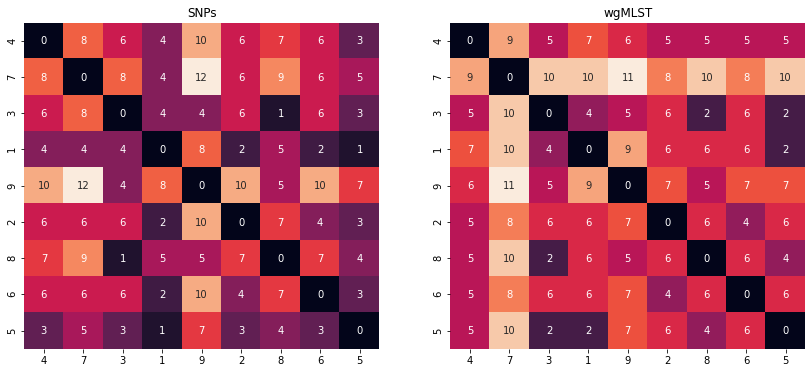

In [158]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
sns.heatmap(sd,annot=True,cbar=False,ax=ax[0])
sns.heatmap(D,annot=True,cbar=False,ax=ax[1])
ax[0].set_title('SNPs')
ax[1].set_title('wgMLST')
plt.savefig('sim_dist_heatmaps.png')

In [136]:
import dendropy
from dendropy.calculate import treecompare
tns = dendropy.TaxonNamespace()
reftree = dendropy.Tree.get(path='sim.newick', schema='newick',taxon_namespace=tns)
tree1 = dendropy.Tree.get(path='mlst3.newick', schema='newick',taxon_namespace=tns)
tree2 = dendropy.Tree.get(path='sim_results1/RAxML_bestTree.variants', schema='newick',taxon_namespace=tns)


In [138]:
print(treecompare.euclidean_distance(reftree, tree1))
print(treecompare.euclidean_distance(reftree, tree2))

4.898976053175999
5.389472890360061
